In [1]:
import os
import numpy as np
import pandas as pd
import mne
from mne.decoding import SPoC
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,corrmap)
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from mne.time_frequency import psd_multitaper, tfr_multitaper, tfr_morlet
import warnings
from sklearn.model_selection import ShuffleSplit
from mne.preprocessing import Xdawn
from operator import itemgetter
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_predict
from mne.decoding import CSP, cross_val_multiscore
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from Channel_Selector import order_channels
from Start_And_Finish_Markers import Start_And_Finish_Markers
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

### Loading the Data

In [2]:
# Load a sample of the folder 
#(fdt files are detected and read automatically when .set is inferenced)
sample_data_raw_file = '3TM_01-100.set'
raw = mne.io.read_raw_eeglab(sample_data_raw_file)

Reading C:\Users\thoma\Desktop\MSc - Research Project\PRE_ICA_new_analyses\3TM_01-100.fdt


### Independant Component Analysis (Manual)

In [3]:
# Filter slow drifts. Removing low-frequency drifts can negatively affect quality of an ICA fit
filt_raw = raw.load_data().copy().filter(l_freq=1., h_freq=None)

Reading 0 ... 1594039  =      0.000 ...  3188.078 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



In [4]:
# Fitting and plotting the ICA solution
# The more number of components we have, the more accurate our solution and the better our artifacts isolated, 
# however using more components is computationally expensive. So if you can use fewer, it's better 
warnings.filterwarnings("ignore", category=DeprecationWarning)
ica = ICA(n_components=30, max_iter='auto', random_state=97)
ica.fit(filt_raw)
ica

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 45.2s.


<ICA | raw data decomposition, method: fastica (fit in 43 iterations on 1594040 samples), 30 ICA components explaining 100.0 % of variance (63 PCA components available), channel types: eeg, no sources marked for exclusion>

In [5]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
ica.plot_components()

[<MNEFigure size 702x696.24 with 20 Axes>,
 <MNEFigure size 702x357.12 with 10 Axes>]

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metada

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\mne\viz\ica.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize, facecolor=[0.95] * 3)


Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1594 matching events found
No baseline correction applied


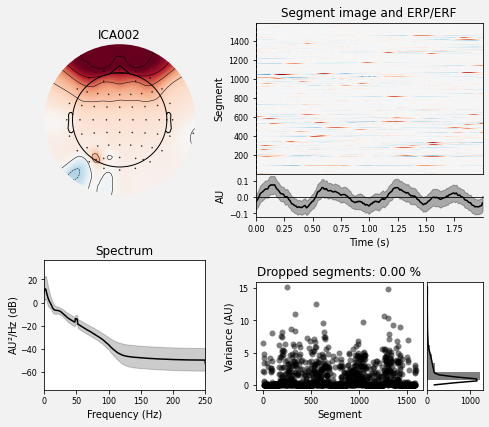

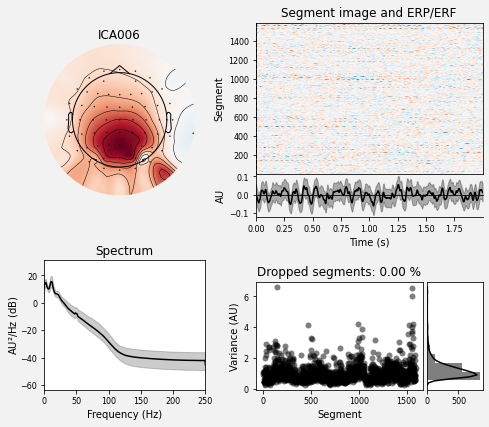

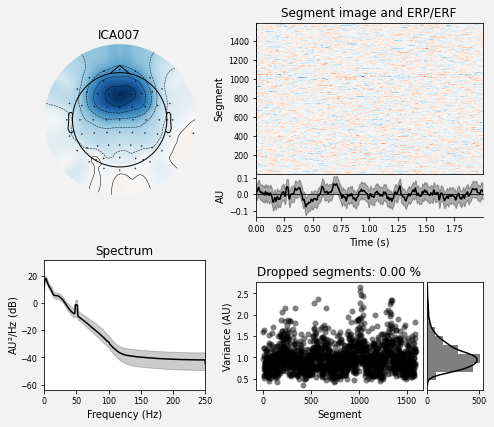

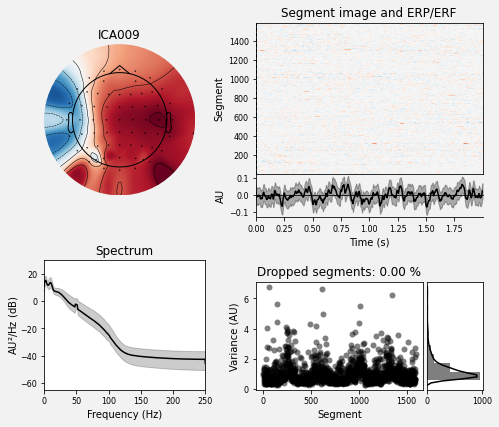

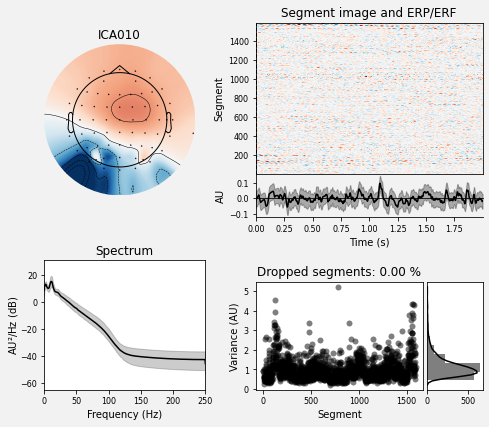

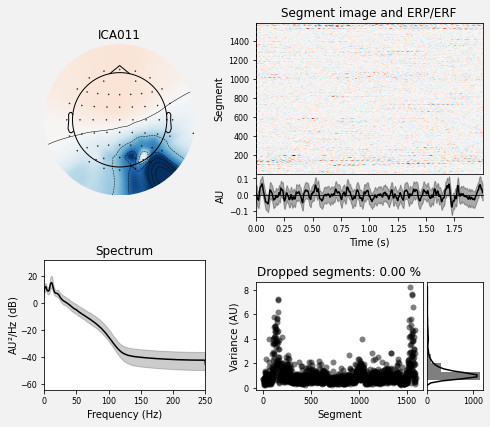

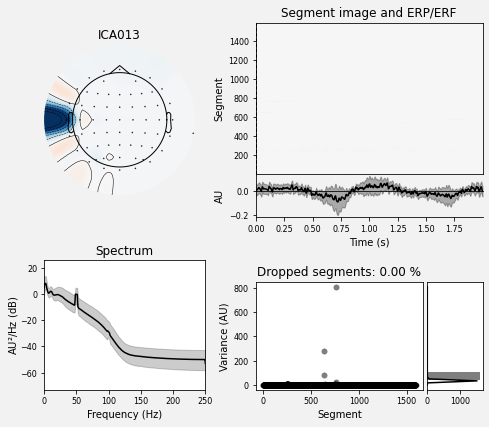

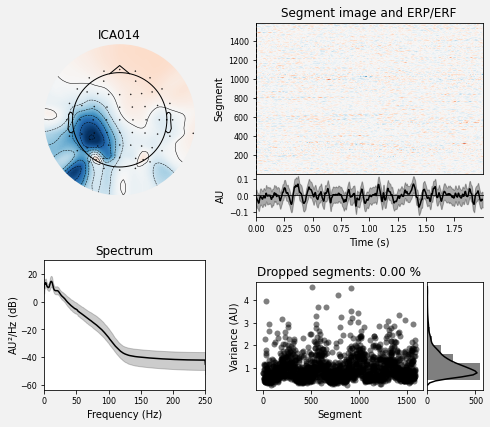

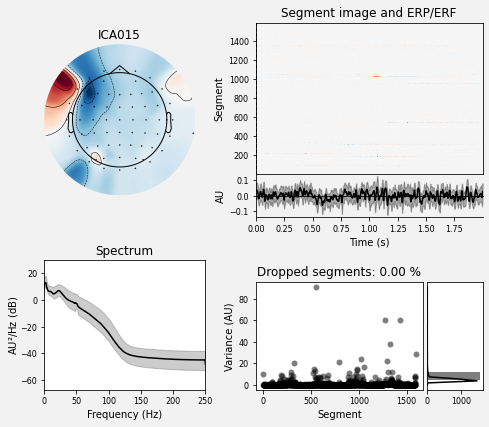

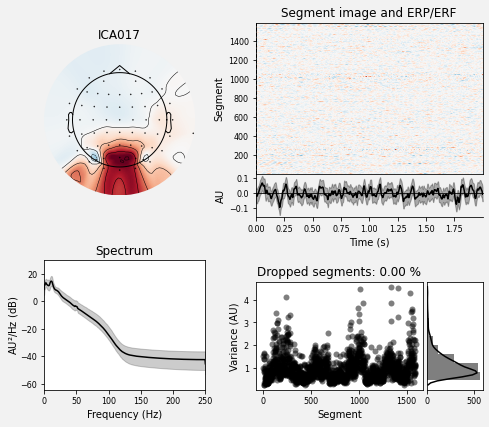

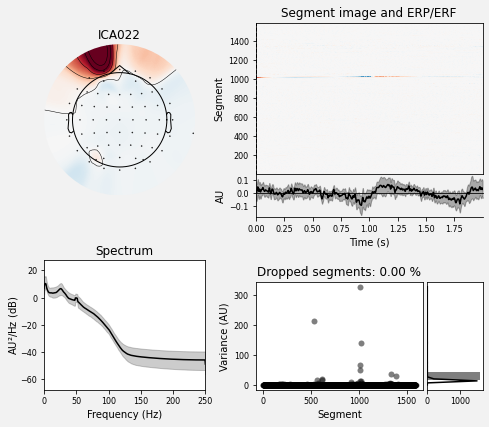

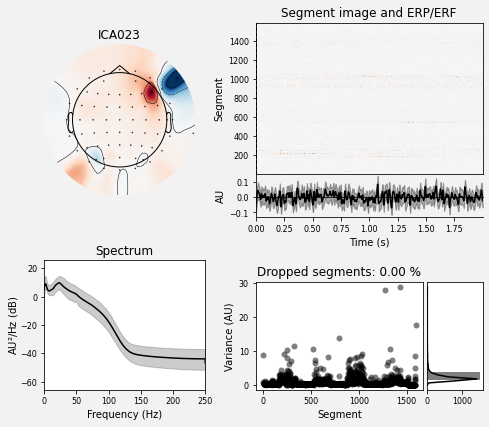

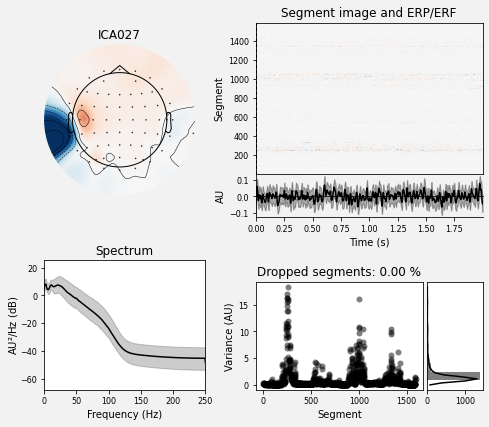

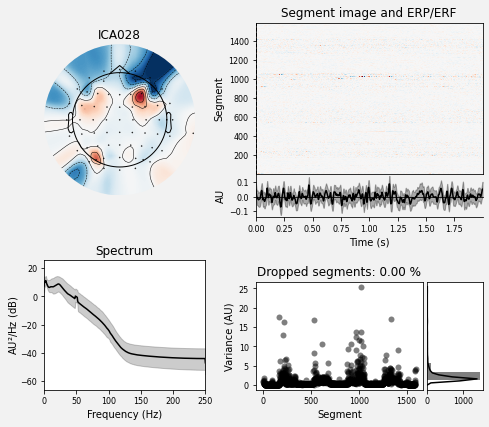

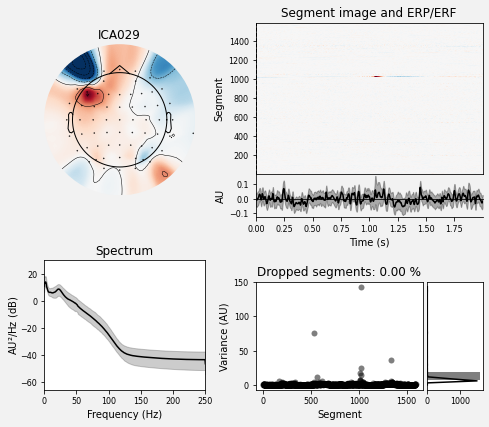

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6

In [6]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
ica.plot_properties(raw, picks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])

In [7]:
ica.exclude = [2,3]

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components
Using matplotlib as 2D backend.


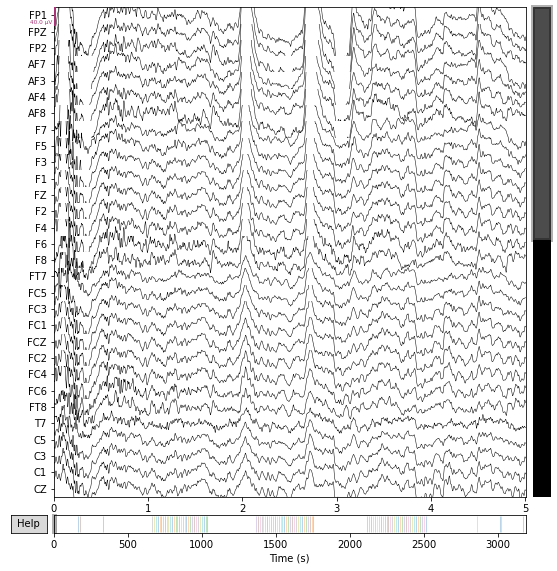

In [8]:
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(raw)

reconst_raw.plot(duration=5, n_channels=30)
raw.plot(duration=5, n_channels=30)
del reconst_raw

In [9]:
raw.drop_channels(["PO5", "M2", "PO6"])

<RawEEGLAB | 3TM_01-100.fdt, 60 x 1594040 (3188.1 s), ~729.8 MB, data loaded>

### Epoching the data

In [10]:
WarmWaterStart, WarmWaterEnd, HotWaterStart, HotwaterEnd, SoundStimuliStart, SoundStimuliEnd, EyesOpenStart, EyesOpenStartFin, EyesClosedStart, EyesClosedStartFin, EyesOpenEnd, EyesOpenEndFin, EyesClosedEnd, EyesClosedEndFin = Start_And_Finish_Markers(raw)

Used Annotations descriptions: ['1.0', '100.0', '11.0', '12.0', '13.0', '14.0', '15.0', '16.0', '17.0', '18.0', '19.0', '20.0', '21.0', '22.0', '23.0', '24.0', '25.0', '26.0', '27.0', '28.0', '29.0', '30.0', '31.0', '32.0', '33.0', '34.0', '35.0', '36.0', '37.0', '38.0', '39.0', '4.0', '40.0', '41.0', '42.0', '43.0', '44.0', '45.0', '46.0', '47.0', '48.0', '49.0', '5.0', '50.0', '51.0', '52.0', '53.0', '54.0', '55.0', '56.0', '57.0', '58.0', '59.0', '6.0', '60.0', '61.0', '62.0', '63.0', '64.0', '65.0', '66.0', '67.0', '68.0', '69.0', '7.0', '70.0', '71.0', '72.0', '73.0', '74.0', '75.0', '76.0', '77.0', '78.0', '79.0', '80.0', '81.0', '82.0', '83.0', '84.0', '85.0', '86.0', '87.0', '88.0', '89.0', '90.0', '91.0', '92.0', '93.0', '94.0', '95.0', '96.0', '97.0', '98.0', '99.0']


In [11]:
# Cropping our experimental events based on the first and last event times 
WarmWaterEmersion = raw.copy().crop(tmin=WarmWaterStart, tmax=WarmWaterEnd)
SoundStimuli = raw.copy().crop(tmin=SoundStimuliStart, tmax=SoundStimuliEnd)
HotWaterEmersion = raw.copy().crop(tmin=HotWaterStart, tmax=HotwaterEnd)
EyesOpenStart = raw.copy().crop(tmin=EyesOpenStart, tmax=EyesOpenStartFin)
EyesClosedStart = raw.copy().crop(tmin=EyesClosedStart, tmax=EyesClosedStartFin)
EyesOpenEnd = raw.copy().crop(tmin=EyesOpenEnd, tmax=EyesOpenEndFin)
EyesClosedEnd = raw.copy().crop(tmin=EyesClosedEnd, tmax=EyesClosedEndFin)

In [12]:
HW_Epochs = mne.make_fixed_length_epochs(HotWaterEmersion, duration=10, preload=True)
WW_Epochs = mne.make_fixed_length_epochs(WarmWaterEmersion, duration=10, preload=True)
SS_Epochs = mne.make_fixed_length_epochs(SoundStimuli, duration=10, preload=True)
EO_Start_Epochs = mne.make_fixed_length_epochs(EyesOpenStart, duration=10, preload=True)
EC_Start_Epochs = mne.make_fixed_length_epochs(EyesClosedStart, duration=10, preload=True)
EO_End_Epochs = mne.make_fixed_length_epochs(EyesOpenEnd, duration=10, preload=True)
EC_End_Epochs = mne.make_fixed_length_epochs(EyesClosedEnd, duration=10, preload=True)

Not setting metadata
Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
Loading data for 38 events and 5000 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
Loading data for 36 events and 5000 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Loading data for 30 events and 5000 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Loading data for 14 events and 5000 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Loading data for 14 events and 5000 o

In [13]:
# Our end goal here is a numpy array that is trials x channels x frequencies 
# So we loop through our conditions, then loop through each trial in each 
# Condition. Then we calculate the psds for that trial in the form (channels x frequencies)
# Then we concatenate a label to the end so we can keep track of where it comes
# from. Then we add it to our global list. 
#Conditions = [HW_Epochs, WW_Epochs, EO_Start_Epochs, EC_Start_Epochs, SS_Epochs, EO_End_Epochs, EC_End_Epochs]   
#Conditions = [EO_Start_Epochs, EC_Start_Epochs]
Conditions = [HW_Epochs, WW_Epochs]

Global_List_Of_Data = []
for condition in Conditions:
    for trial_number in range(len(condition)):
        # Delta
        #psds, freqs = psd_multitaper(condition[trial_number], fmin=0.5, fmax=4, n_jobs=1)
        # Theta
        #psds, freqs = psd_multitaper(condition[trial_number], fmin=4, fmax=8, n_jobs=1)
        # Alpha
        psds, freqs = psd_multitaper(condition[trial_number], fmin=8, fmax=12, n_jobs=1)
        # Beta
        #psds, freqs = psd_multitaper(condition[trial_number], fmin=12, fmax=30, n_jobs=1)
        # Gamma
        #psds, freqs = psd_multitaper(condition[trial_number], fmin=35, fmax=40, n_jobs=1)
        Current = list(psds[0])
        if condition == HW_Epochs:
            Current.append(0)
        elif condition == WW_Epochs:
            Current.append(1)
        elif condition == EO_Start_Epochs:
            Current.append(2)
        elif condition == EC_Start_Epochs:
            Current.append(3)
        elif condition == SS_Epochs:
            Current.append(4)
        elif condition == EO_End_Epochs:
            Current.append(5)
        elif condition == EC_End_Epochs:
            Current.append(6)
        Global_List_Of_Data.append(Current)
        


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spe

In [14]:
# Because we are working with numpy arrays I have manually shuffled our results.
# Once it's shuffled I can extract our concatented labels
# So that we now have Global_List_Of_Data which is all our training data
# and we now have Labels which is all our labels
# Both of which are in the same order (even after having been shuffled)
np.random.shuffle(Global_List_Of_Data)
Labels = []
for i in range(len(Global_List_Of_Data)):
    Labels.append(Global_List_Of_Data[i][-1])
    Global_List_Of_Data[i] = Global_List_Of_Data[i][:-1]


In [15]:
# All classes
Split_Ratio = round(len(Global_List_Of_Data) * 0.8)
print(Split_Ratio)
training_X, test_X, training_Y, test_Y = Global_List_Of_Data[:Split_Ratio], Global_List_Of_Data[Split_Ratio:],Labels[:Split_Ratio],Labels[Split_Ratio:]

59


In [16]:
X = np.asarray(Global_List_Of_Data)
y = np.asarray(Labels)

### Common Spatial Patterns + SVM Training and Predictions

In [17]:
# FOR COMMON SPATIAL PATTERNS + SUPPORT VECTOR MACHINE

# Define our common spatial filters and our classifier model
clf = SVC(kernel='linear') # Linear Kernel
csp = CSP(n_components=4)
# Make a pipeline from the given estimators
# This pipeline will sequentially apply a list of transformations and a final 
# estimator.
classifier_pipeline_CSP = make_pipeline(csp,clf)

# Cross validation split. 
cv = StratifiedKFold(n_splits=10, shuffle=True)

# Now we can calculate the cross validation scores when applying our training
# data to the newly made pipeline
scores_CSP = cross_val_score(classifier_pipeline_CSP, X, y, cv=cv)

print(" CSP + SVM Classification accuracy: %f" % (np.mean(scores_CSP)))

Computing rank from data with rank=None
    Using tolerance 1.2e-08 (2.2e-16 eps * 60 dim * 9.1e+05  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-08 (2.2e-16 eps * 60 dim * 8.8e+05  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-08 (2.2e-16 eps * 60 dim * 8.1e+05  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-08 (2.2e-16 eps * 60 dim * 8.5e+05  max singular value)


Computing rank from data with rank=None
    Using tolerance 1.3e-08 (2.2e-16 eps * 60 dim * 9.4e+05  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.2e-08 (2.2e-16 eps * 60 dim * 9.2e+05  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Done.


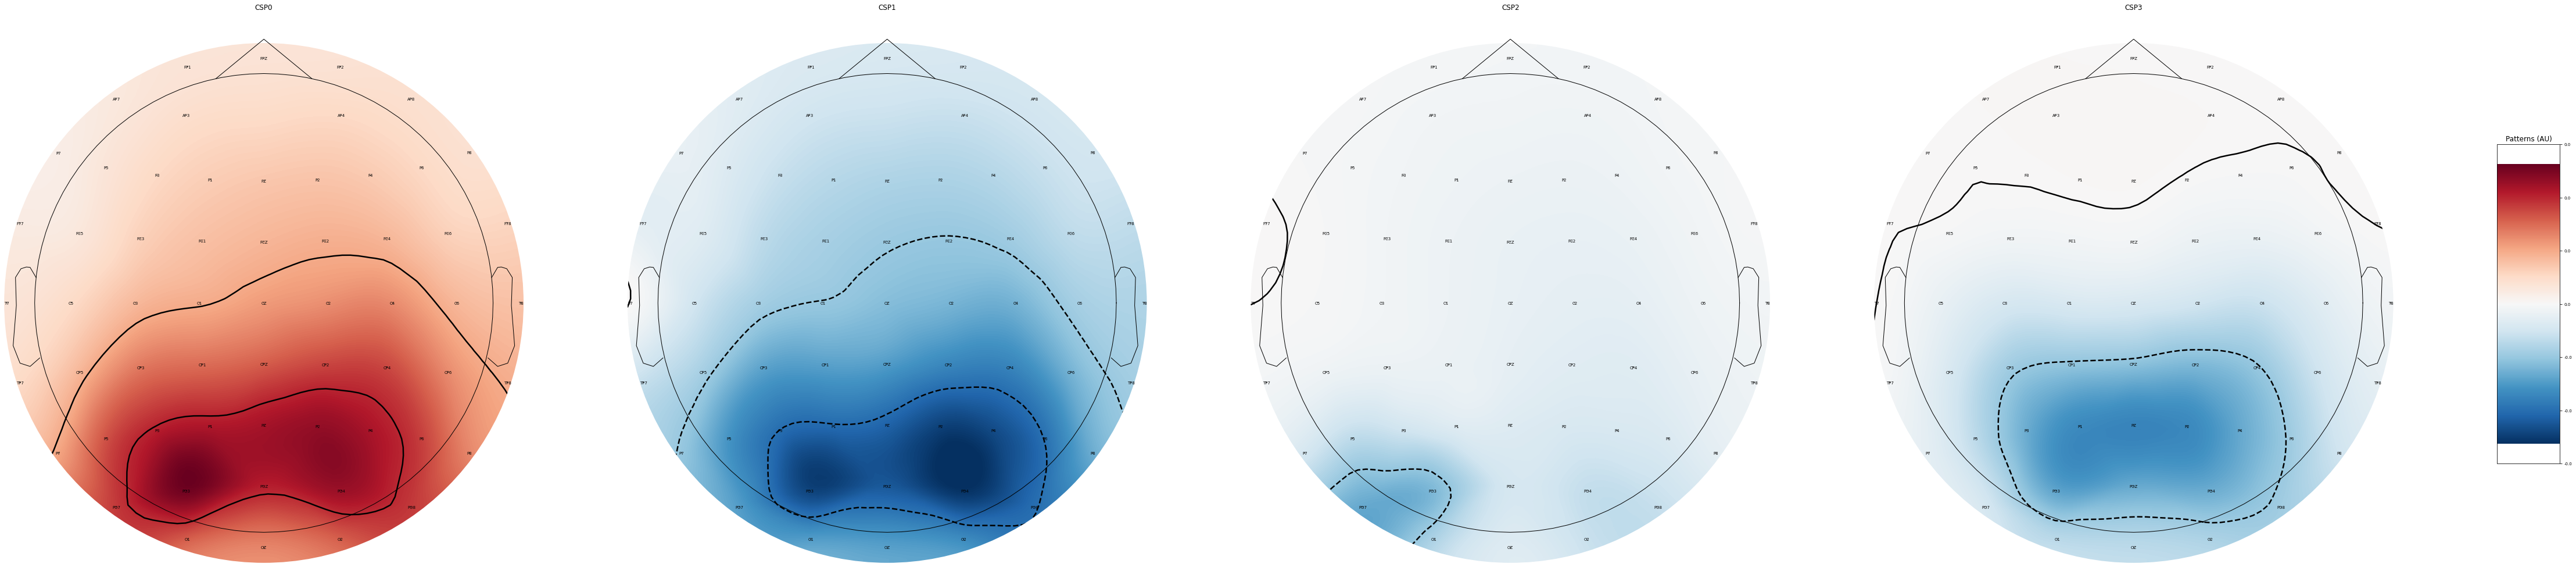

In [18]:
analysis_csp_X = X.copy()
analysis_csp_y = y.copy()
csp.fit_transform(analysis_csp_X, analysis_csp_y)
csp.plot_patterns(EC_Start_Epochs.info, units='Patterns (AU)', size=10, show_names=True)
print("")

In [19]:
# FOR SPoC + Support Vector MACHINE 
clf = SVC(kernel='linear') # Linear Kernel
spoc = SPoC()
classifier_pipeline_spoc = make_pipeline(spoc, clf)
cv = KFold(n_splits=2, shuffle=True)
y_preds_spoc = cross_val_predict(classifier_pipeline_spoc, X, y, cv=cv)

# Calculate the accuracy based on the predictions made
counter = 0
for i in range(len(y)):
    if y[i] == y_preds_spoc[i]:
        counter+=1 
print(counter / len(y))

Computing rank from data with rank=None
    Using tolerance 1.3e-09 (2.2e-16 eps * 41 dim * 1.5e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.6e-10 (2.2e-16 eps * 41 dim * 9.5e+04  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-09 (2.2e-16 eps * 41 dim * 2.6e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 

    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.1e-10 (2.2e-16 eps * 41 dim * 6.7e+04  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-09 (2.2e-16 eps * 41 dim * 1.4e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.3e-10 (2.2e-16 eps * 41 dim * 1e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 comp

    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.9e-10 (2.2e-16 eps * 41 dim * 1.1e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 9.8e-10 (2.2e-16 eps * 41 dim * 1.1e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-09 (2.2e-

Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1e-09 (2.2e-16 eps * 41 dim * 1.1e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.2e-10 (2.2e-16 eps * 41 dim * 6.8e+04  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.8e-10 (2.2e-16 eps * 41 dim * 5.3e+04  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (w

In [20]:
# FOR RIEMANNIAN CLASSIFICATION + SUPPORT VECTOR MACHINE 

# This is a different version of what we have just done above. 
# This time we are using Riemannian classification by matrices manipulation
# and using the tanget space.
clf = SVC(kernel='linear') # Linear Kernel
covest = Covariances()
ts = TangentSpace()

# Cross validation split. 
cv = StratifiedKFold(n_splits=10, shuffle=True)

# Make a pipeline from the given estimators
# This pipeline will sequentially apply a list of transformations and a final 
# estimator.
classifier_pipeline_Riemannian = make_pipeline(covest, ts, clf)
scores_RIE = cross_val_score(classifier_pipeline_Riemannian, X, y, cv=cv)

print("  RIE + SVM Classification accuracy: %f" % (np.mean(scores_RIE)))

C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\pyriemann\utils\base.py:14: RuntimeWarning: invalid value encountered in log
  eigvals = np.diag(operator(eigvals))
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\pyriemann\utils\base.py:14: RuntimeWarning: invalid value encountered in log
  eigvals = np.diag(operator(eigvals))
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\pyriemann\utils\base.py:14: RuntimeWarning: invalid value encountered in log
  eigvals = np.diag(operator(eigvals))
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\pyriemann\utils\base.py:14: RuntimeWarning: invalid value encountered in log
  eigvals = np.diag(operator(eigvals))
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\pyriemann\utils\base.py:14: RuntimeWarning: invalid value encountered in log
  eigvals = np.diag(operator(eigvals))
C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\si

  RIE + SVM Classification accuracy: nan


C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\thoma\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\

Computing rank from data with rank=None
    Using tolerance 6.4e-10 (2.2e-16 eps * 41 dim * 7.1e+04  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-09 (2.2e-16 eps * 41 dim * 1.5e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-09 (2.2e-16 eps * 41 dim * 1.2e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 

    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-09 (2.2e-16 eps * 41 dim * 2.3e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-09 (2.2e-16 eps * 41 dim * 1.2e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.5e-10 (2.2e-16 eps * 41 dim * 7.1e+04  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 co

    Using tolerance 1.1e-09 (2.2e-16 eps * 41 dim * 1.2e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 4.6e-10 (2.2e-16 eps * 41 dim * 5.1e+04  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-09 (2.2e-16 eps * 41 dim * 1.3e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL

Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.4e-10 (2.2e-16 eps * 41 dim * 5.9e+04  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-09 (2.2e-16 eps * 41 dim * 2.5e+05  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 60 -> 41
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-10 (2.2e-16 eps * 41 dim * 9.2e+04  max singular value)
    Estimated rank (mag): 41
    MAG: rank 41 computed from 60 data channels with 0 projectors
    Setti

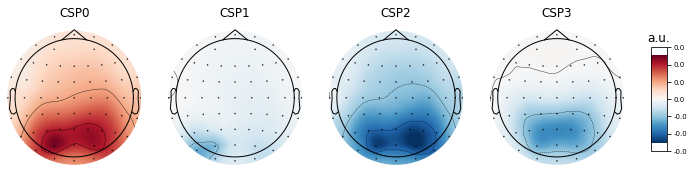

In [21]:
analysis_spoc_X = X.copy()
analysis_spoc_y = y.copy()
spoc.fit(analysis_spoc_X, analysis_spoc_y)
spoc.plot_patterns(EO_Start_Epochs.info,size=1.5)
print("")